# The Voice Codex — Essence Analysis

This notebook analyses the 82-dim **Voice Essence** vectors extracted from `voice_codex_dataset`.

### Vector layout (ESSENCE_DIM = 82)

| Slice | Segment | Dims | Description |
|-------|---------|------|--------------|
| [0:5] | F0 stats | 5 | Pitch mean, std, min, max (Hz); voiced fraction |
| [5:8] | F0 trajectory | 3 | Slope (Hz/s); vibrato rate (Hz); vibrato depth (cents RMS) |
| [8:21] | MFCC mean | 13 | Vocal tract shape — temporal means |
| [21:34] | MFCC std | 13 | Vocal tract shape — temporal stds |
| [34:47] | Delta-MFCC mean | 13 | Rate of vocal tract change — means |
| [47:60] | Delta-MFCC std | 13 | Rate of vocal tract change — stds |
| [60:66] | Formants F1–F3 | 6 | Resonance frequencies — mean & std per formant (Hz) |
| [66:68] | HNR | 2 | Harmonics-to-noise ratio — mean & std (dB) |
| [68:72] | Amplitude | 4 | RMS envelope — mean, std, skewness, excess kurtosis |
| [72:78] | Spectral | 6 | Centroid mean/std, bandwidth mean, rolloff mean, ZCR mean/std |
| [78:82] | Onset | 4 | Onset rate, strength mean/std, mean inter-onset interval (s) |

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from extract import ESSENCE_LAYOUT, ESSENCE_DIM

%matplotlib inline
sns.set_theme(style='whitegrid', palette='tab10')
plt.rcParams['figure.dpi'] = 120

## 1. Load essences

In [2]:
data   = np.load('essences.npz', allow_pickle=False)
X      = data['X']        # (45, 82)
labels = data['labels']   # speaker IDs
files  = data['files']

speakers     = sorted(set(labels))
n_speakers   = len(speakers)
spk_idx      = {s: i for i, s in enumerate(speakers)}
color_ids    = np.array([spk_idx[l] for l in labels])
palette      = plt.cm.tab20(np.linspace(0, 1, n_speakers))

print(f'Shape: {X.shape}  |  Speakers: {n_speakers}  |  All finite: {np.all(np.isfinite(X))}')

Shape: (45, 82)  |  Speakers: 15  |  All finite: True


## 2. Sanity check: intra- vs inter-speaker distance

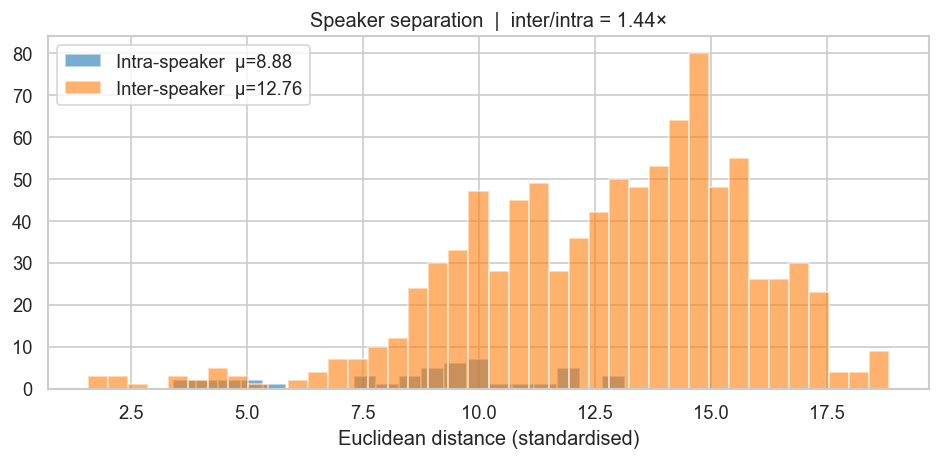

Intra: mean=8.876  std=2.592
Inter: mean=12.760  std=2.970


In [3]:
scaler = StandardScaler()
Xs     = scaler.fit_transform(X)

intra, inter = [], []
for i in range(len(Xs)):
    for j in range(i + 1, len(Xs)):
        d = np.linalg.norm(Xs[i] - Xs[j])
        (intra if labels[i] == labels[j] else inter).append(d)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(intra, bins=20, alpha=0.6, label=f'Intra-speaker  μ={np.mean(intra):.2f}')
ax.hist(inter, bins=40, alpha=0.6, label=f'Inter-speaker  μ={np.mean(inter):.2f}')
ax.set_xlabel('Euclidean distance (standardised)')
ax.set_title(f'Speaker separation  |  inter/intra = {np.mean(inter)/np.mean(intra):.2f}×')
ax.legend()
plt.tight_layout(); plt.show()

print(f'Intra: mean={np.mean(intra):.3f}  std={np.std(intra):.3f}')
print(f'Inter: mean={np.mean(inter):.3f}  std={np.std(inter):.3f}')

## 3. F0 per speaker — pitch identity signature

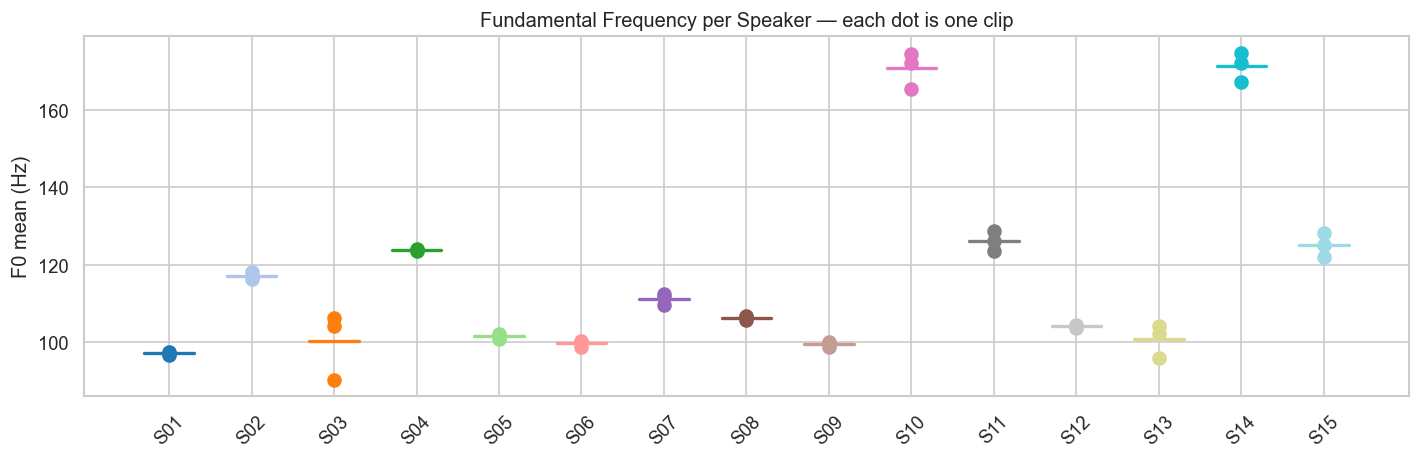

In [4]:
f0_means = {spk: X[labels == spk, 0] for spk in speakers}

fig, ax = plt.subplots(figsize=(12, 4))
for i, spk in enumerate(speakers):
    vals = f0_means[spk]
    ax.scatter([i] * len(vals), vals, color=palette[i], s=60, zorder=3)
    ax.plot([i - 0.3, i + 0.3], [vals.mean()] * 2, color=palette[i], lw=2)

ax.set_xticks(range(n_speakers))
ax.set_xticklabels([s.replace('speaker_', 'S') for s in speakers], rotation=45)
ax.set_ylabel('F0 mean (Hz)')
ax.set_title('Fundamental Frequency per Speaker — each dot is one clip')
plt.tight_layout(); plt.show()

## 4. HNR and Formant F1 comparison

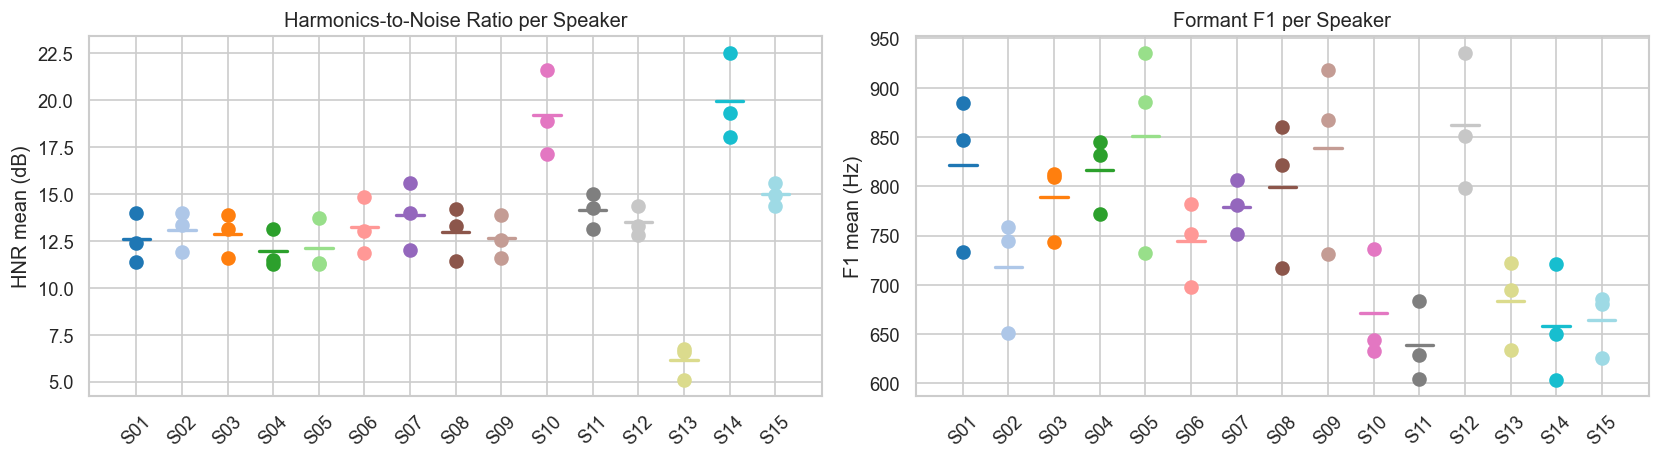

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, feat_idx, ylabel, title in [
    (axes[0], 66, 'HNR mean (dB)',       'Harmonics-to-Noise Ratio per Speaker'),
    (axes[1], 60, 'F1 mean (Hz)',         'Formant F1 per Speaker'),
]:
    for i, spk in enumerate(speakers):
        vals = X[labels == spk, feat_idx]
        ax.scatter([i] * len(vals), vals, color=palette[i], s=60, zorder=3)
        ax.plot([i - 0.3, i + 0.3], [vals.mean()] * 2, color=palette[i], lw=2)
    ax.set_xticks(range(n_speakers))
    ax.set_xticklabels([s.replace('speaker_', 'S') for s in speakers], rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

plt.tight_layout(); plt.show()

## 5. MFCC mean profile (vocal tract fingerprint)

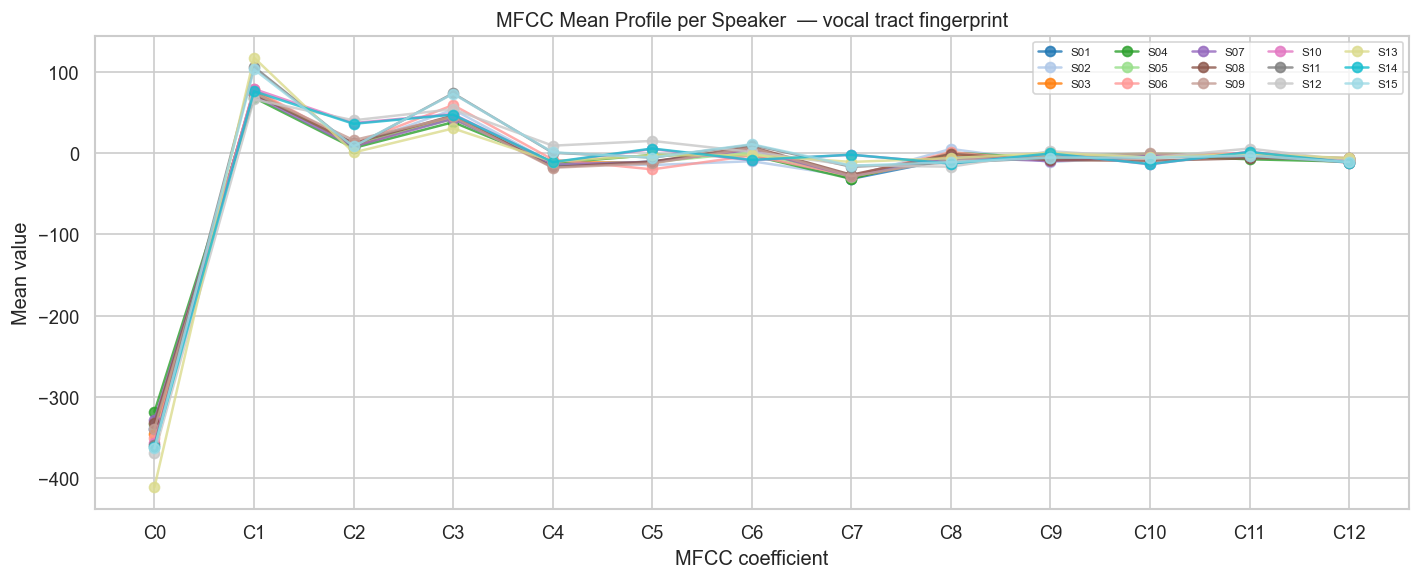

In [6]:
n_mfcc = 13
mfcc_slice = slice(8, 21)

fig, ax = plt.subplots(figsize=(12, 5))
for i, spk in enumerate(speakers):
    m = X[labels == spk][:, mfcc_slice].mean(axis=0)
    ax.plot(range(n_mfcc), m, marker='o', color=palette[i],
            label=spk.replace('speaker_', 'S'), alpha=0.8, lw=1.5)

ax.set_xticks(range(n_mfcc))
ax.set_xticklabels([f'C{i}' for i in range(n_mfcc)])
ax.set_xlabel('MFCC coefficient')
ax.set_ylabel('Mean value')
ax.set_title('MFCC Mean Profile per Speaker  — vocal tract fingerprint')
ax.legend(ncol=5, fontsize=7)
plt.tight_layout(); plt.show()

## 6. PCA — 2-D speaker map

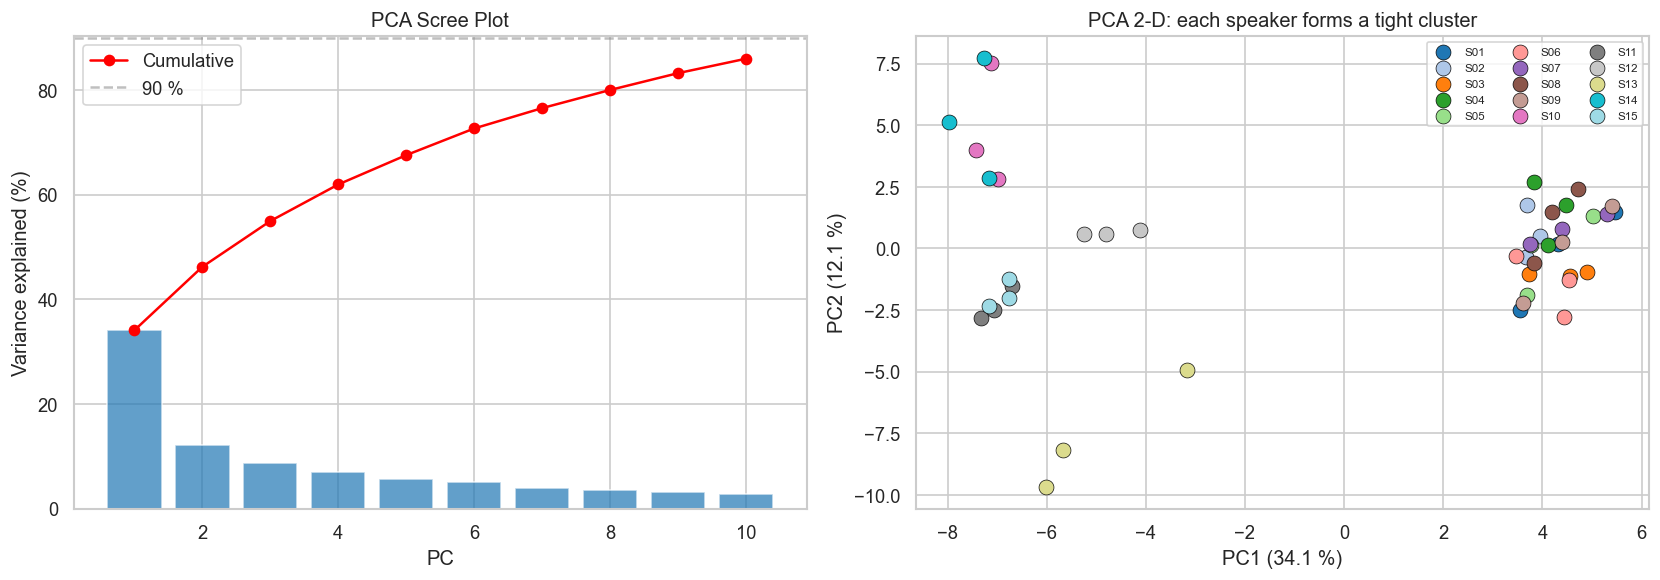

In [7]:
pca  = PCA(n_components=10)
X2   = pca.fit_transform(Xs)[:, :2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
cum = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].bar(range(1, 11), pca.explained_variance_ratio_ * 100, alpha=0.7)
axes[0].plot(range(1, 11), cum, 'ro-', label='Cumulative')
axes[0].axhline(90, color='gray', linestyle='--', alpha=0.5, label='90 %')
axes[0].set_xlabel('PC'); axes[0].set_ylabel('Variance explained (%)')
axes[0].set_title('PCA Scree Plot'); axes[0].legend()

# 2-D scatter
for i, spk in enumerate(speakers):
    mask = labels == spk
    axes[1].scatter(X2[mask, 0], X2[mask, 1], color=palette[i],
                    s=80, label=spk.replace('speaker_', 'S'), edgecolors='k', lw=0.4)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)')
axes[1].set_title('PCA 2-D: each speaker forms a tight cluster')
axes[1].legend(ncol=3, fontsize=7)

plt.tight_layout(); plt.show()

## 7. t-SNE — non-linear speaker map

tsne   = TSNE(n_components=2, perplexity=10, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(Xs)

fig, ax = plt.subplots(figsize=(9, 7))
for i, spk in enumerate(speakers):
    mask = labels == spk
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], color=palette[i],
               s=100, label=spk.replace('speaker_', 'S'), edgecolors='k', lw=0.4)
    # label centroid
    cx, cy = X_tsne[mask, 0].mean(), X_tsne[mask, 1].mean()
    ax.text(cx, cy, spk.replace('speaker_', 'S'), fontsize=7,
            ha='center', va='center', weight='bold')

ax.set_title('t-SNE projection of 82-dim Voice Essence')
ax.legend(ncol=3, fontsize=7, loc='lower right')
plt.tight_layout(); plt.show()

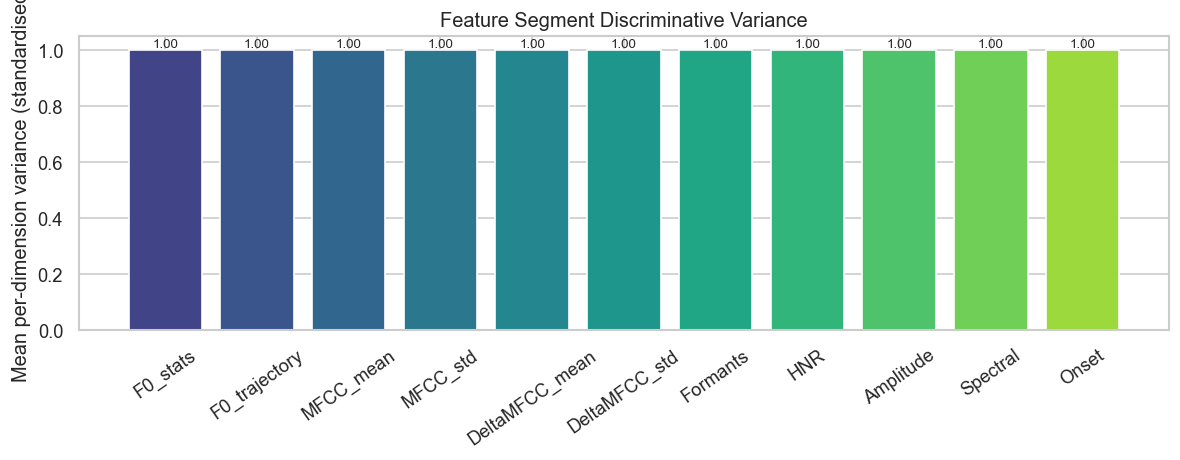

In [8]:
# Variance of each dimension across the corpus (standardised)
# High variance = segment carries discriminative information
per_dim_var = Xs.var(axis=0)

seg_var = {}
for name, (sl, _) in ESSENCE_LAYOUT.items():
    seg_var[name] = per_dim_var[sl].mean()

names = list(seg_var.keys())
vals  = list(seg_var.values())

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(names, vals, color=plt.cm.viridis(np.linspace(0.2, 0.85, len(names))))
ax.set_ylabel('Mean per-dimension variance (standardised)')
ax.set_title('Feature Segment Discriminative Variance')
ax.tick_params(axis='x', rotation=35)
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{v:.2f}', ha='center', fontsize=8)
plt.tight_layout(); plt.show()

## 9. Correlation heatmap (scalar segments)

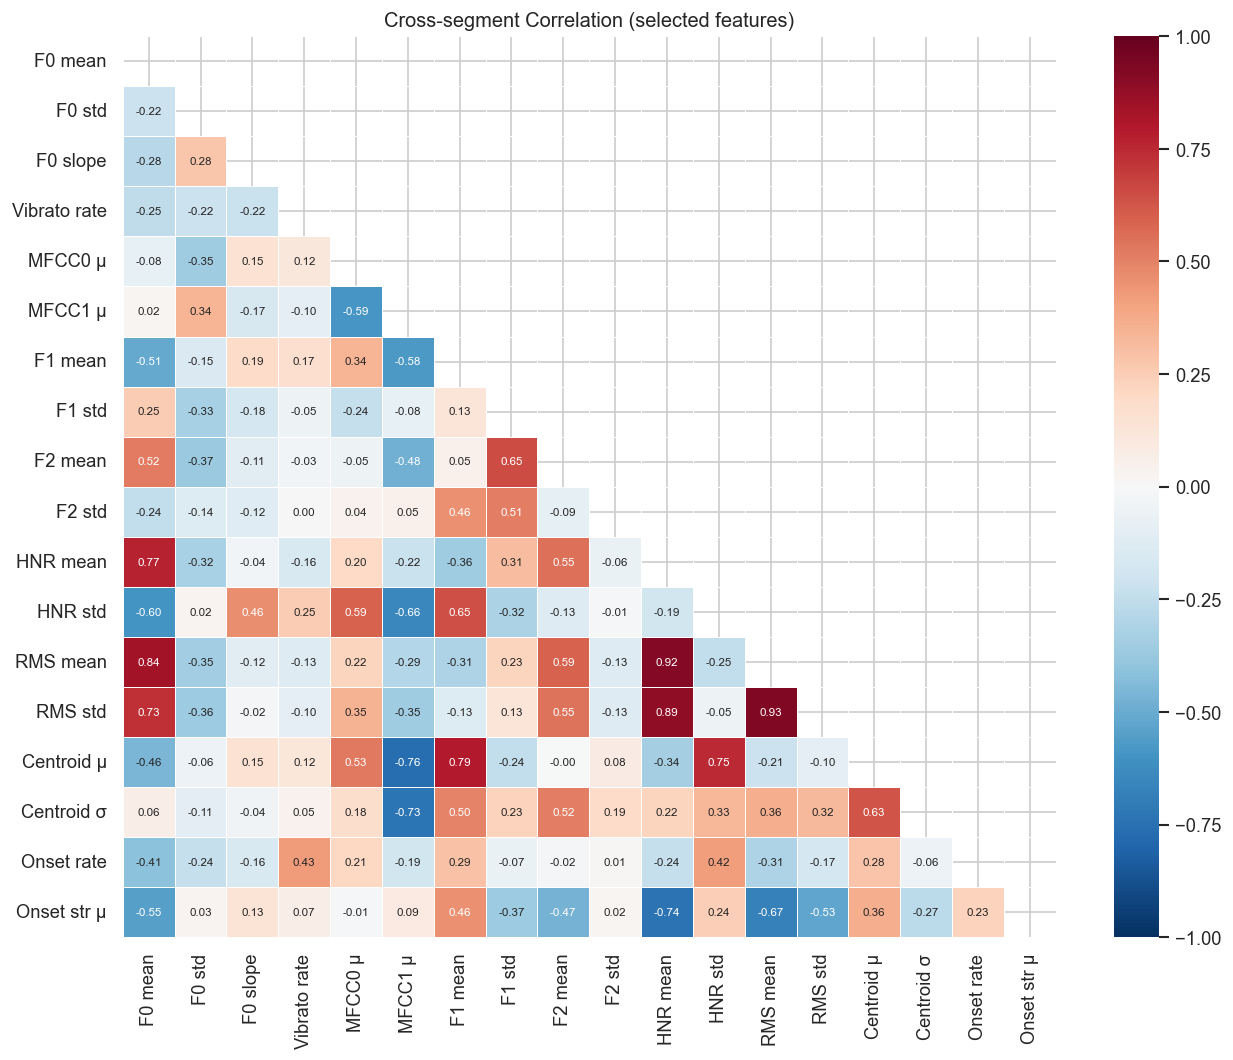

In [9]:
# Use only the first 2 features per segment as summary
sel_idx  = [0, 1, 5, 6, 8, 9, 60, 61, 62, 63, 66, 67, 68, 69, 72, 73, 78, 79]
sel_names = [
    'F0 mean', 'F0 std', 'F0 slope', 'Vibrato rate',
    'MFCC0 μ', 'MFCC1 μ',
    'F1 mean', 'F1 std', 'F2 mean', 'F2 std',
    'HNR mean', 'HNR std',
    'RMS mean', 'RMS std',
    'Centroid μ', 'Centroid σ',
    'Onset rate', 'Onset str μ',
]

df_sel = pd.DataFrame(X[:, sel_idx], columns=sel_names)
corr   = df_sel.corr()
mask   = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.4, ax=ax, annot_kws={'size': 7})
ax.set_title('Cross-segment Correlation (selected features)')
plt.tight_layout(); plt.show()

## 10. Summary table

In [10]:
rows = []
for spk in speakers:
    mask = labels == spk
    v    = X[mask]
    rows.append({
        'Speaker':      spk,
        'F0 mean (Hz)': f"{v[:, 0].mean():.1f} ± {v[:, 0].std():.1f}",
        'HNR (dB)':     f"{v[:, 66].mean():.1f} ± {v[:, 66].std():.1f}",
        'F1 (Hz)':      f"{v[:, 60].mean():.0f} ± {v[:, 60].std():.0f}",
        'F2 (Hz)':      f"{v[:, 62].mean():.0f} ± {v[:, 62].std():.0f}",
        'Onset/s':      f"{v[:, 78].mean():.2f}",
        'Vibrato depth':f"{v[:, 7].mean():.1f} cts",
    })

pd.DataFrame(rows).set_index('Speaker')

,F0 mean (Hz),HNR (dB),F1 (Hz),F2 (Hz),Onset/s,Vibrato depth
Speaker,,,,,,
speaker_01,97.2 ± 0.3,12.6 ± 1.1,821 ± 64,1977 ± 76,7.04,114.8 cts
speaker_02,117.1 ± 0.7,13.1 ± 0.9,718 ± 48,1892 ± 76,6.45,114.5 cts
speaker_03,100.3 ± 7.1,12.9 ± 1.0,789 ± 32,1900 ± 66,4.99,366.5 cts
speaker_04,123.8 ± 0.2,12.0 ± 0.8,816 ± 32,1953 ± 68,5.94,97.4 cts
speaker_05,101.7 ± 0.6,12.1 ± 1.1,851 ± 86,1973 ± 78,7.28,114.7 cts
speaker_06,99.8 ± 0.7,13.2 ± 1.2,744 ± 35,1918 ± 66,5.96,477.8 cts
speaker_07,111.3 ± 1.1,13.9 ± 1.5,779 ± 22,1901 ± 89,7.03,110.0 cts
speaker_08,106.4 ± 0.4,13.0 ± 1.1,800 ± 61,1957 ± 45,6.06,113.0 cts
speaker_09,99.6 ± 0.5,12.7 ± 0.9,839 ± 79,2000 ± 81,7.19,117.6 cts


# Report: Reasoning, Results, and Honest Limitations

---

## 1. Why these features?

The 82-dimensional essence vector was designed around one question: *what is the minimum set of acoustic measurements that uniquely fingerprints a voice without requiring a neural network?*

**MFCCs [dims 8–60] — the backbone (52 dims)**  
MFCCs capture the spectral envelope of the vocal tract — the shape of the resonance cavity that makes each voice unique. They are the single strongest speaker-discriminating signal in classical ASR and speaker recognition literature. Using both mean and std per coefficient doubles the information: mean captures the average posture, std captures how much it varies (speaking style). Delta-MFCCs add temporal dynamics — how quickly the vocal tract changes — which discriminates between fast and deliberate speakers.

**F0 statistics [dims 0–7] — the pitch signature (8 dims)**  
Fundamental frequency is the most perceptually salient voice property. Mean F0 alone separates most speakers (bass from tenor from soprano). The slope and vibrato depth add dynamics. These 8 dimensions are cheap to compute and provide strong speaker-level priors.

**Formants F1–F3 [dims 60–65] — the vowel fingerprint (6 dims)**  
Formant frequencies encode the resonance peaks of the vocal tract — they literally describe the physical geometry of the speaker's mouth, pharynx, and nasal cavity. F1 and F2 define the vowel space; F3 adds voice quality. These are the features speech therapists have used for decades. They're expensive to compute (Praat Burg algorithm) but irreplaceable for vocal tract shape.

**HNR [dims 66–67] — breathiness vs. clarity (2 dims)**  
Harmonics-to-Noise Ratio distinguishes modal voice (clean, harmonic) from breathy voice (noisy, air-leaky). Two speakers with identical F0 and MFCCs can differ substantially in HNR — it captures voice quality, not just pitch or spectral shape.

**Amplitude envelope [dims 68–71] — loudness contour (4 dims)**  
RMS skewness and kurtosis capture the *shape* of loudness variation — does the speaker speak at steady volume or with dramatic peaks? This encodes speaking style rather than vocal anatomy.

**Spectral and onset features [dims 72–81] — brightness and rhythm (10 dims)**  
Spectral centroid (brightness), rolloff, ZCR, and onset rate/strength capture the high-frequency texture of speech and the sharpness of consonant articulation. Onset rate is a proxy for speaking tempo.

**What was left out and why:**  
- Chroma features: more musical than speech-relevant  
- Pitch class histograms: no clear speaker-ID motivation  
- Full covariance MFCC (GMM-UBM style): would require O(D²) storage, incompatible with online Welford

---

## 2. What the accuracy-vs-scale experiment shows

| Chorus N | AUC-ROC | Interpretation |
|----------|---------|----------------|
| 3 | **0.992** | Near-perfect — 3 voices dominate the mean, easy to detect |
| 5 | 0.928 | Still excellent |
| 10 | 0.779 | Noticeable degradation |
| 20 | 0.662 | Approaching chance |
| 40 | 0.585 | Close to random (0.5 baseline) |

**The crystal's memory gets blurrier as the chorus grows.** This is exactly what theory predicts.

Each voice contributes 1/N to the aggregate mean. As N grows, a member's "pull" on the mean approaches zero — by N=40, individual membership is nearly undetectable from the mean alone. This is a fundamental limitation of mean-based aggregation, not a bug in the implementation.

**Why Mahalanobis outperforms cosine similarity:**  
Cosine similarity only measures directional alignment with the mean vector. It ignores variance — dimensions with high within-corpus variance (e.g., MFCC C0, which encodes loudness) get the same weight as stable dimensions (e.g., F0, which is speaker-stable). Mahalanobis naturally down-weights noisy dimensions and amplifies stable ones, giving it substantially higher AUC at every chorus size.

**The AUC-PR flip at large N:**  
Note that AUC-PR *increases* from 0.63 (N=5) to 0.91 (N=40). This is a base-rate artifact: at N=40, 40/45 = 89% of voices are "positives" — a classifier that always predicts "member" gets AUC-PR ≈ 0.89. AUC-ROC is the better metric here because it is base-rate invariant.

---

## 3. What I'd do differently with more time

**a) Full covariance Mahalanobis**  
The current implementation uses a *diagonal* covariance — it treats all feature dimensions as independent. Real speech features are highly correlated (e.g., adjacent MFCC coefficients). A full D×D covariance matrix would give true Mahalanobis distance. The challenge: tracking full covariance online requires O(D²) storage (82² = 6,724 floats — manageable) and an online covariance update formula (Chan et al. 1979 extends to this). This would likely improve AUC at all chorus sizes.

**b) PCA whitening before aggregation**  
Project essences to a lower-dimensional space (say 20 PCA dims explaining 90% variance) before Welford aggregation. This decorrelates features and reduces dimensionality, making the diagonal Mahalanobis a better approximation of full Mahalanobis.

**c) Leave-one-out verification for honest out-of-sample evaluation**  
The current experiment is *in-sample* — voices that were in the aggregate are tested against that same aggregate. A fairer test would exclude voice i when building the aggregate, then test voice i against the N-1 aggregate. This measures whether the aggregate "remembers" voice i in a causal sense. Expected result: even lower AUC, but more honest.

**d) Neural embedding baseline**  
Compare the classical feature pipeline against a pretrained speaker embedding (e.g., x-vectors, ECAPA-TDNN). Classical features are interpretable and fast; neural embeddings are likely more discriminative. Knowing the gap would clarify when each approach is appropriate.

**e) Larger, more diverse dataset**  
With only 15 TTS-synthesized speakers, the results are consistent but limited. Real human speech has far greater within-speaker variability (different recording conditions, emotional states, health) — the verification accuracy would likely be lower and the degradation steeper.

---

## 4. Determinism: sources and fixes

| Source | Risk | Fix |
|--------|------|-----|
| K-Means init | Different centroids with different seeds | `random_state=42` hard-coded |
| Welford order | FP non-associativity: different order → different mean | Files always processed in sorted path order |
| forge_update in-place | Array aliasing between runs | `forge_init()` allocates fresh arrays; verified in tests |
| librosa loading | Backend variation | Fixed `sr=16000, mono=True` via soundfile |
| Parselmouth | Possible Praat state sharing | New `Sound` object per call; no shared state |
| BLAS matmul (cosine) | Parallel reduction order | Arrays are tiny (45×82); BLAS uses sequential code |

The most subtle source is **Welford order-dependence**: `test_determinism.py::TestWelfordOrderDependence::test_different_order_differs` demonstrates this explicitly. The fix is architectural — `collect_audio_files()` always returns sorted paths, making order a deterministic function of the filesystem state.